# CSE 190: Fairness, bias, and transparency in Machine Learning

# Assignment 2


In [155]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

## <ins>Exploratory analysis and fairness metrics</ins>



In [156]:
dataset_path = kagglehub.dataset_download("utkarshx27/which-resume-attributes-drive-job-callbacks")
df = pd.read_csv(dataset_path + "/resume.csv")
print(df.shape)
df.head()


(4870, 30)


,job_ad_id,job_city,job_industry,job_type,job_fed_contractor,job_equal_opp_employer,job_ownership,job_req_any,job_req_communication,job_req_education,...,honors,worked_during_school,years_experience,computer_skills,special_skills,volunteer,military,employment_holes,has_email_address,resume_quality
0,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,0,6,1,0,0,0,1,0,low
1,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,1,6,1,0,1,1,0,1,high
2,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,1,6,1,0,0,0,0,0,low
3,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,0,6,1,1,1,0,1,1,high
4,385,Chicago,other_service,secretary,0.0,1,nonprofit,1,0,0,...,0,1,22,1,0,0,0,0,1,high


#### Dataset Context:

The dataset was collected to analyze how the perceived race of a job applicant (as indicated by their name) affects their chances of receiving a callback from employers. The study investigates whether White-sounding names receive more callbacks than African American-sounding names, controlling for resume quality and other factors.
<br/><br/>

Dataset Collection:
- Researchers sent out 4870 fake resumes in response to 1,344 job postings in newspapers from Chicago and Boston.
- Each job posting received four resumes, two of higher quality and two of lower quality.
- Half of the resumes were assigned White-sounding names (e.g., Emily Walsh, Greg Baker), and the other half were assigned African American-sounding names (e.g., Lakisha Washington, Jamal Jones).
- Researchers then tracked which resumes received callbacks from employers.
<br/><br/>

Dataset features:
- Name assigned to the resume (name is meant to communicate the applicant's gender and race.)
- Resume features
  - Inferred gender associated with the first name on the resume
  - Inferred race associated with the first name on the resume
  - Years of college education listed on the resume
  - Indicator for if the resume listed a college degree
  - Indicator for if the resume listed that the candidate has been awarded some honors
  - Indicator for if the resume listed working while in school
  - Years of experience listed on the resume
  - Indicator for if computer skills were listed on the resume
  - Indicator for if any special skills were listed on the resume
  - Indicator for if volunteering was listed on the resume
  - Indicator for if military experience was listed on the resume
  - Indicator for if there were holes in the person's employment history
  - Indicator for if the resume lists an email address
  - Each resume was generally classified as either lower or higher quality
- Job ad details
  - City where the job was located
  - Industry of the job
  - Type of role
  - Indicator for if the employer is a federal contractor
  - Indicator for if the employer is an Equal Opportunity Employer
  - The type of company, e.g. a nonprofit or a private company
  - Indicator for if any job requirements are listed. If so, the other job_req_* fields give more detail
  - Indicator for if communication skills are required
  - Indicator for if some level of education is required
  - Amount of experience required
  - Indicator for if computer skills are required
  - Indicator for if organization skills are required
  - Level of education required
  - Indicator for if there was a callback from the job posting for the person listed on this resume
- Indicator for if there was a callback from the job posting for the person listed on this resume

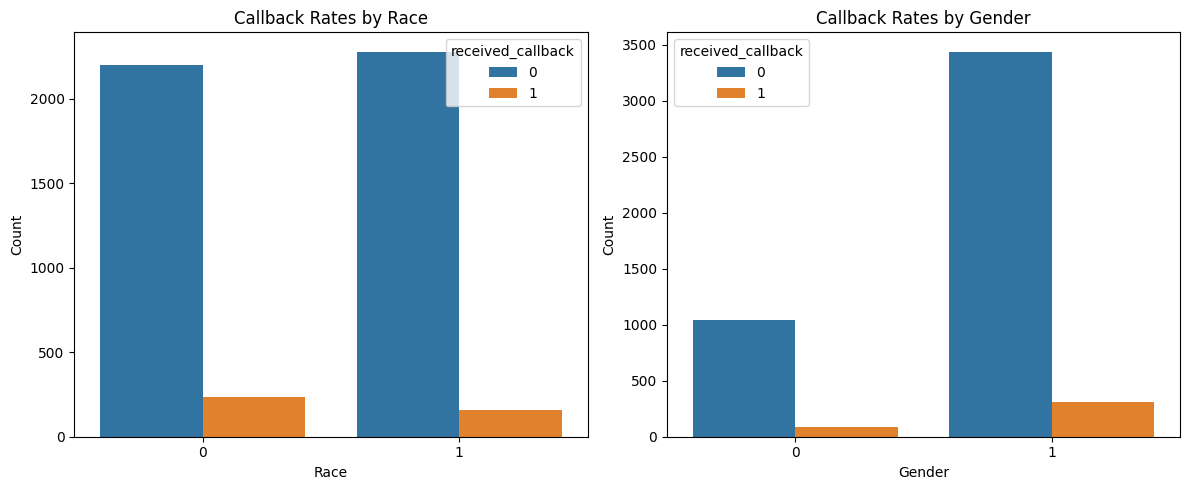

job_equal_opp_employer    0
job_req_any               0
job_req_communication     0
job_req_education         0
job_req_computer          0
job_req_organization      0
received_callback         0
race                      0
gender                    0
years_college             0
college_degree            0
honors                    0
worked_during_school      0
years_experience          0
computer_skills           0
special_skills            0
volunteer                 0
military                  0
employment_holes          0
has_email_address         0
resume_quality            0
dtype: int64


In [154]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.countplot(x="race", hue="received_callback", data=df, ax=axes[0])
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Count")
axes[0].set_title("Callback Rates by Race")

sns.countplot(x="gender", hue="received_callback", data=df, ax=axes[1])
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Count")
axes[1].set_title("Callback Rates by Gender")
plt.tight_layout()
plt.show()

print(df.isnull().sum())

### Data Cleaning

1. We will convert race, gender, and resume quality to binary labels.
   - race: White -> 0, Black -> 1
   - gender: Male (m) -> 0, Female (f) -> 1
   - resume_quality: Low -> 0, High -> 1
<br/><br/>

1. We will drop these features
   - 'firstname' - Does not matter as the first name information is held within the race and gender features
   - job_ad_id – A unique job identifier, not relevant
   - job_city – Not relevant
   - job_industry – Not relevant
   - job_type – The type of job (e.g., full-time, part-time) may not be necessary for our study.
   - job_ownership – Not relevant
   - job_req_min_experience – Not relevant
   - job_req_school – Not relevant
   - job_fed_contractor - lots of NaN

In [148]:
df['race'] = df['race'].map({'white': 0, 'black': 1})
df['gender'] = df['gender'].map({'m': 0, 'f': 1})
df['resume_quality'] = df['resume_quality'].map({'low': 0, 'high': 1})
df = df.drop(columns=['firstname', 'job_ad_id', 'job_city', 'job_industry', 'job_type', 'job_ownership', 'job_req_min_experience', 'job_req_school', 'job_fed_contractor', ])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4870 entries, 0 to 4869
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   job_equal_opp_employer  4870 non-null   int64
 1   job_req_any             4870 non-null   int64
 2   job_req_communication   4870 non-null   int64
 3   job_req_education       4870 non-null   int64
 4   job_req_computer        4870 non-null   int64
 5   job_req_organization    4870 non-null   int64
 6   received_callback       4870 non-null   int64
 7   race                    4870 non-null   int64
 8   gender                  4870 non-null   int64
 9   years_college           4870 non-null   int64
 10  college_degree          4870 non-null   int64
 11  honors                  4870 non-null   int64
 12  worked_during_school    4870 non-null   int64
 13  years_experience        4870 non-null   int64
 14  computer_skills         4870 non-null   int64
 15  special_skills       

In [149]:
X = df.drop(columns=['received_callback'])
y = df['received_callback']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(class_weight="balanced", max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

precision = report['1']['precision']
recall = report['1']['recall']
f1 = report['1']['f1-score']

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (True Positive Rate): {recall:.4f}")
print(f"F1-score: {f1:.4f}")

def fairness_metrics(y_true, y_pred, sensitive_feature):
    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)

    def compute_tpr(y_true_group, y_pred_group):
        tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
        fn = np.sum((y_pred_group == 0) & (y_true_group == 1))
        return tp / (tp + fn) if (tp + fn) > 0 else 0

    def compute_fpr(y_true_group, y_pred_group):
        fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
        tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
        return fp / (fp + tn) if (fp + tn) > 0 else 0

    tpr_0 = compute_tpr(y_true[group_0], y_pred[group_0])
    tpr_1 = compute_tpr(y_true[group_1], y_pred[group_1])
    fpr_0 = compute_fpr(y_true[group_0], y_pred[group_0])
    fpr_1 = compute_fpr(y_true[group_1], y_pred[group_1])

    return tpr_0, fpr_0, tpr_1, fpr_1

tpr_0, fpr_0, tpr_1, fpr_1 = fairness_metrics(y_test.to_numpy(), y_pred, X_test['race'].to_numpy())


print("\nFairness Metrics (Race as Sensitive Attribute):")
print(f"TPR (White) : {tpr_0:.4f}")
print(f"FPR (White) : {fpr_0:.4f}")
print(f"TPR (Black) : {tpr_1:.4f}")
print(f"FPR (Black) : {fpr_1:.4f}")


Accuracy: 0.6386
Precision: 0.1337
Recall (True Positive Rate): 0.6410
F1-score: 0.2212

Fairness Metrics (Race as Sensitive Attribute):
TPR (White) : 0.7609
FPR (White) : 0.4522
TPR (Black) : 0.4688
FPR (Black) : 0.2824


DISCUSSION

## <ins>Interventions</ins>

4. Code: How much can “unfairness” in your predictions be explained by dataset
characteristics? Can you fix them with dataset-based interventions?

    Say a little something about the code cell for 4.

In [150]:
# 4. Code

5. Code: How do different modeling choices impact fairness characteristics? Can
you fix them with in-processing interventions?

    Say a little something about different modeling choices impacting fairness, and in-processing intervention

In [151]:
# 5. Code

6. Code: Can you apply post-processing interventions to achieve desired fairness
outcomes?

    Talk about post processing intervention for the following code cell

In [152]:
# 6. Code

7. Discussion: What types of interventions are most appropriate for your task (e.g.
legal, practical to deploy, etc.)? What are the tradeoffs between them (e.g. how
are other metrics negatively impacted by a particular intervention, etc.)

## <ins>Research Paper</ins>

8. Context: Summarize the main contributions of the paper and its relevance to
your task.

9. Code: Attempt to reproduce results similar to those reported in the paper on your
dataset (or comment in detail about any failure to do so)

    Say something like in the following code cell we will attempt to reproduce these results

In [153]:
# 9. Code

10. Discussion: Is it more effective than other intervention strategies you tried? Why
or why not? Conclude your presentation with a general discussion of what was
and was not effective for your task.